<a href="https://colab.research.google.com/github/SpearFlex/eye_diseases/blob/main/eye_diseases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Автоматическая модель определения глазных заболеваний на основе анализа снимков глазного дна технологиями ИИ для автоматической системы скрининга патологий глаза человека

Импорт зависимостей

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np

Загрузка датасета с GDrive

In [ ]:
!gdown --id 1Hloj7IZjIs44M_X9unaJWj9ddrAXPZwy

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Hloj7IZjIs44M_X9unaJWj9ddrAXPZwy
From (redirected): https://drive.google.com/uc?id=1Hloj7IZjIs44M_X9unaJWj9ddrAXPZwy&confirm=t&uuid=3df8ffad-7b09-4fb4-9e81-e14cf80f5bfa
To: /content/eye_diseases.zip
100% 771M/771M [00:04<00:00, 189MB/s]


Установка дополнительной зависимости

In [ ]:
!pip install split_folders

Распаковка архива

In [ ]:
!unzip -n eye_diseases.zip

Archive:  eye_diseases.zip
  inflating: dataset/cataract/0_left.jpg  
  inflating: dataset/cataract/103_left.jpg  
  inflating: dataset/cataract/1062_right.jpg  
  inflating: dataset/cataract/1083_left.jpg  
  inflating: dataset/cataract/1084_right.jpg  
  inflating: dataset/cataract/1102_left.jpg  
  inflating: dataset/cataract/1102_right.jpg  
  inflating: dataset/cataract/1115_left.jpg  
  inflating: dataset/cataract/1126_right.jpg  
  inflating: dataset/cataract/112_right.jpg  
  inflating: dataset/cataract/1144_left.jpg  
  inflating: dataset/cataract/1144_right.jpg  
  inflating: dataset/cataract/1164_left.jpg  
  inflating: dataset/cataract/1167_right.jpg  
  inflating: dataset/cataract/119_left.jpg  
  inflating: dataset/cataract/1285_left.jpg  
  inflating: dataset/cataract/1415_left.jpg  
  inflating: dataset/cataract/1415_right.jpg  
  inflating: dataset/cataract/1435_left.jpg  
  inflating: dataset/cataract/1444_left.jpg  
  inflating: dataset/cataract/1452_left.jpg  
  inf

In [ ]:
# Делим на train, val и test
import splitfolders

input_folder = "/content/dataset" # Ввод
output = "/content/ready_dataset" # Вывод

splitfolders.ratio(input_folder, output=output, seed=432, ratio=(0.8, 0.1, 0.1))

Copying files: 4217 files [00:03, 1345.13 files/s]


In [ ]:
batch_size = 32
img_height = 256
img_width = 256

train_ds = tf.keras.utils.image_dataset_from_directory(
  directory='ready_dataset/train', # путь к папке с обучающими данными
  label_mode = 'int',       # представление правильных ответов картинок в виде чисел (Label Encoding): 0, 1, 2, 3...
  color_mode='rgb',         # представление каждой картинки в RGB формате
  batch_size=batch_size,    # параметр, с помощью которого можно регулировать порцию подаваемых примеров (картинок) для сети за одну итерацию обучения
  seed=123,
  image_size=(img_height, img_width), # нейронная сеть всегда принимает изображение определённого размера. Поэтому необходимо предварительно поменять размер каждого изображения
  shuffle=True)                       # перетасовка данных, чтобы генерировать данные не в определённом порядке (сначала 1 класс, потом 2 класс), а случайным образом

val_ds = tf.keras.utils.image_dataset_from_directory(
  directory='ready_dataset/val',  # путь к папке с валидационный данными
  label_mode = 'int',
  color_mode='rgb',
  batch_size=batch_size,
  seed=123,
  image_size=(img_height, img_width),
  shuffle=False) # Для тестовых и валидационных данных обычно не рекомендуется включать shuffle (перемешивание). Важно сохранить порядок этих данных, чтобы избежать внесения случайных изменений в процесс оценки модели.

test_ds = tf.keras.utils.image_dataset_from_directory(
  directory='ready_dataset/test',  # путь к папке с тестовыми данными
  label_mode = 'int',
  color_mode='rgb',
  batch_size=batch_size,
  seed=123,
  image_size=(img_height, img_width),
  shuffle=False)

Found 3372 files belonging to 4 classes.
Found 419 files belonging to 4 classes.
Found 426 files belonging to 4 classes.


In [ ]:
class_names = train_ds.class_names # список классов
num_classes = len(class_names) # количество классов, чтобы указать их в последнем выходном слое

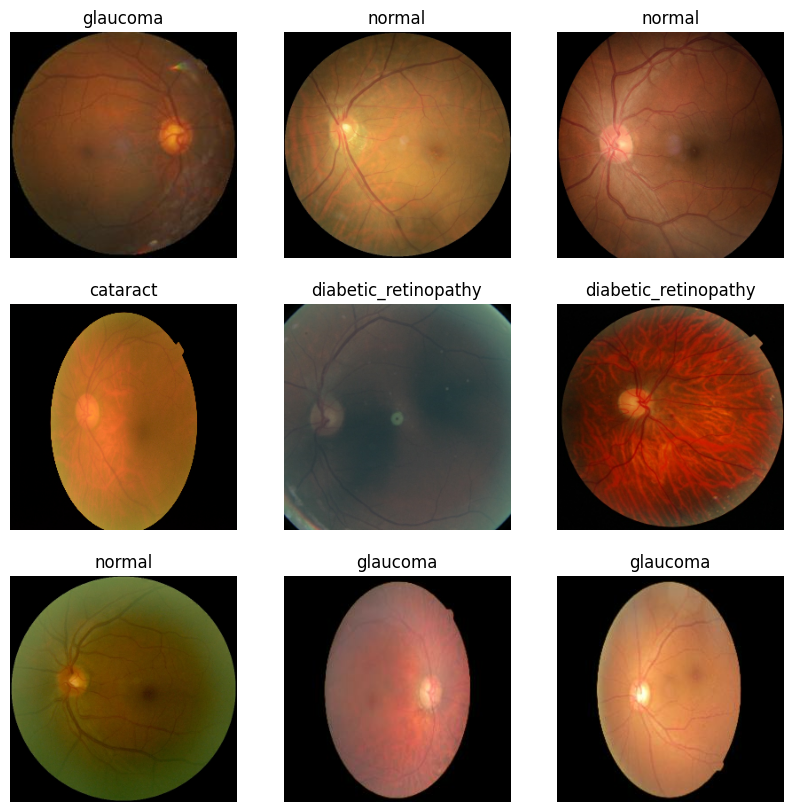

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
def createModel(input_shape):
    # Входной слой
    input_layer = Input(shape=input_shape)

    # Нормализация данных от 0 до 1
    normalized_layer = Rescaling(1./255)(input_layer)

    # 1 блок свёртки
    conv_1 = Conv2D(filters=40, kernel_size=(3, 3), activation='relu', padding='same') (normalized_layer)
    pool_1 = MaxPooling2D(2, 2) (conv_1)

    # 2 блок свёртки
    conv_2 = Conv2D(50, (3, 3), activation='relu', padding='same') (pool_1)
    drop_2 = Dropout(0.2) (conv_2)

    # 3 блок свёртки
    conv_3 = Conv2D(60, (3, 3), activation='relu', padding='same') (drop_2)
    pool_3 = MaxPooling2D(2, 2) (conv_3)
    drop_3 = Dropout(0.1) (pool_3)

    conv_4 = Conv2D(70, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(1e-4)) (drop_3)
    pool_4 = MaxPooling2D(2, 2) (conv_4)

    averaged_features = GlobalAveragePooling2D()(pool_4)
    flatten_features = Flatten() (averaged_features)
    output = Dense(num_classes, activation='softmax') (flatten_features)

    return Model(inputs=input_layer, outputs=output)

In [ ]:
def compileModel():
  model = createModel((img_height, img_width, 3))
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics='sparse_categorical_accuracy')

  model.summary()
  return model

In [ ]:
model = compileModel()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 40)      1120      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 40)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 50)      18050     
                                                                 
 dropout (Dropout)           (None, 128, 128, 50)      0         
                                                             

In [ ]:
save_callback = ModelCheckpoint(filepath='best_model_weights.h5',
                                monitor = 'val_loss',
                                save_best_only = True,
                                save_weights_only=True,
                                mode = 'min',
                                verbose=1)

In [ ]:
model.fit(train_ds,
        validation_data=val_ds,
        epochs=30,
        callbacks=[save_callback]
        )

Epoch 1/30
106/106 [==============================] - ETA: 0s - loss: 1.2879 - sparse_categorical_accuracy: 0.3698
Epoch 1: val_loss improved from inf to 1.23067, saving model to best_model_weights.h5
106/106 [==============================] - 38s 253ms/step - loss: 1.2879 - sparse_categorical_accuracy: 0.3698 - val_loss: 1.2307 - val_sparse_categorical_accuracy: 0.4940
Epoch 2/30
106/106 [==============================] - ETA: 0s - loss: 1.1839 - sparse_categorical_accuracy: 0.4540
Epoch 2: val_loss improved from 1.23067 to 1.15631, saving model to best_model_weights.h5
106/106 [==============================] - 32s 289ms/step - loss: 1.1839 - sparse_categorical_accuracy: 0.4540 - val_loss: 1.1563 - val_sparse_categorical_accuracy: 0.4893
Epoch 3/30
106/106 [==============================] - ETA: 0s - loss: 1.1469 - sparse_categorical_accuracy: 0.4819
Epoch 3: val_loss improved from 1.15631 to 1.11462, saving model to best_model_weights.h5
106/106 [==============================] - 26

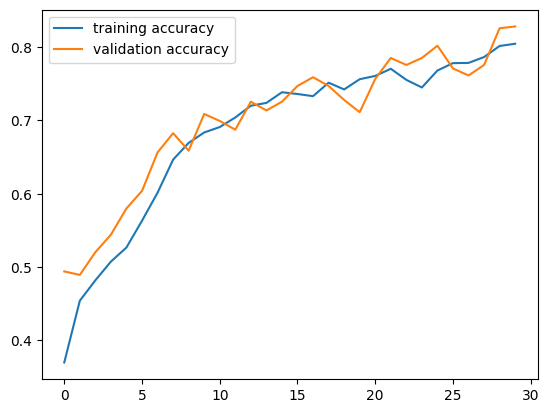

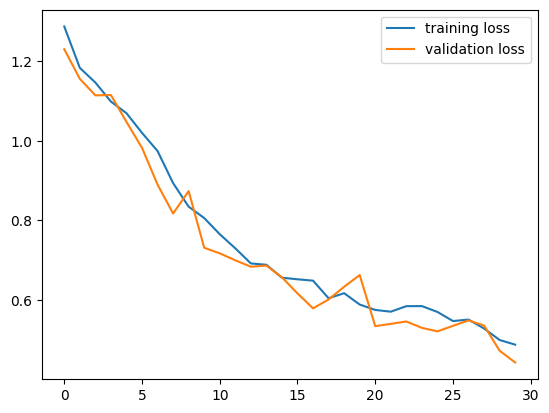

In [ ]:
# Вывод графиков обучения

plt.figure()
plt.plot(model.history.history["sparse_categorical_accuracy"], label="training accuracy")
plt.plot(model.history.history["val_sparse_categorical_accuracy"], label="validation accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(model.history.history["loss"], label="training loss")
plt.plot(model.history.history["val_loss"], label="validation loss")
plt.legend()
plt.show()

In [ ]:
# Загрузка весов самой лучшей модели с самой малеьнокй ошибкой
model.load_weights('best_model_weights.h5')

1/1 [==============================] - 0s 28ms/step
Предсказанный ответ: diabetic_retinopathy
Правильный ответ: diabetic_retinopathy


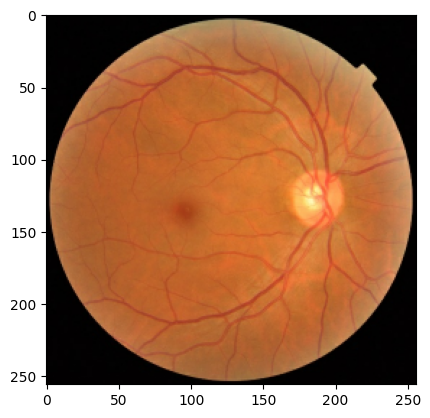

In [ ]:
# Здесь мы берём каждый раз случайное изображение из test_ds и предсказываем для него класс.
# Эту ячейку можно запускать много раз и смотреть результаты классификации для разных картинок.

for image_batch, label_batch in test_ds.shuffle(buffer_size=10).take(1):
    image = image_batch[1]
    label = label_batch[1]
    predictions = model.predict(tf.expand_dims(image, axis=0))
    # Get the predicted class label
    predicted_class_index = tf.argmax(predictions, axis=-1)
    predicted_class_label = test_ds.class_names[predicted_class_index[0]]
    # Print the predicted class label and true label
    print("Предсказанный ответ:", predicted_class_label)
    print("Правильный ответ:", test_ds.class_names[label])
    plt.imshow(image.numpy().astype("uint8"))

In [ ]:
# Эту ячейку вы можете использовать для рассчёта точности по каждому классу.

from sklearn.metrics import accuracy_score
import numpy as np

y_pred = model.predict(test_ds)
predicted_labels = np.argmax(y_pred, axis=1)
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Get unique classes
classes = list(set(true_labels))

# Print accuracy for each class
print("Accuracy by Class:")
for cls in classes:
    cls_true = [true_labels[i] for i in range(len(true_labels)) if predicted_labels[i] == cls]
    cls_pred = [predicted_labels[i] for i in range(len(predicted_labels)) if predicted_labels[i] == cls]
    cls_accuracy = accuracy_score(cls_true, cls_pred)
    print(f"Class {test_ds.class_names[cls]}: {cls_accuracy}")

14/14 [==============================] - 3s 183ms/step
Accuracy by Class:
Class cataract: 0.8541666666666666
Class diabetic_retinopathy: 0.9649122807017544
Class glaucoma: 0.7634408602150538
Class normal: 0.7804878048780488


In [ ]:
# Если нужно использовать ранее обученную  модель


model = createModel((img_height, img_width, 3))


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics='accuracy')


model.load_weights('best_model_weights.h5')